# Image Classification - Detecting Disease from Chest X Rays

Objective: Develop a model that can detect and classify disease from X Ray Images
    
Data Source: This is a custom data set that contains 133 images for each class of Chest X Ray images (4): 
        Healthy, Covid 19, Bacterial Pneumonia, Viral Pneumonia

Data Source 1: https://github.com/ieee8023/covid-chestxray-dataset

Data Source 2: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


In [2]:
#Import relevant packages
import os
import cv2 #OpenCV
import tensorflow as tf #Google's Framework to build and Train Deep Learning Models
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50 #Import Residual Network to perform deep learning
#From Keras we will import pre trained components
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator #to generate tensor images data and normalize them
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler #Early Stopping is to ensure we are not overfitting our model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
#Specify training data directory
X_Ray_Directory = "C:\\Users\\tawsi\\Chest_X_Ray\\Train"

### Data Preprocessing

In [4]:
#Use OS to list the folders in the Directory
os.listdir(X_Ray_Directory)

['0', '1', '2', '3']

From the training data, I use 20% for cross validation and 80% for training. Th Cross validation will allow the model to generalize instead of memorize the order of images

In [5]:
#Use Image Generator to generate tensor images data and normalize them
#Use 20% of the data for cross-validation to make sure that the model is not overfitting the training data.
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2) #generating image data and normalizing them with 1/255 which is random.


In [6]:
#Now let's generate batcheds of 40 images

train_generator = image_generator.flow_from_directory(batch_size = 40, directory = X_Ray_Directory, 
                                                      shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'training')
#In the code above, flow from directory fetches the data, batch size is how many images I want in a batch, directory is the directory above, shuffle is true as we are reshuffling the images.
#We shuffle the images to make sure that the deep learning model is not learning the order of the images

Found 428 images belonging to 4 classes.


I Generate a batch of 40 images. There are 133 images for 4 classes which makes it a total of 532 images. I take 80% of them for training the model (428 images) and 20% of them for validation (104 images). I also shuffled the images to make sure that the model generalizes and doesn't memorize the order of the images.

In [7]:
#Create the Validation subset
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory = X_Ray_Directory, 
                                                      shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'validation')

Found 104 images belonging to 4 classes.


In [8]:
#Obtain a few images by generating a batch of 40 images and labels
train_images, train_labels = next(train_generator) #fetching 40 images


In [9]:
train_images.shape

(40, 256, 256, 3)

Now I have 40 images, each of these images are 256 pixels by 256 pixels by 3 colors.

In [10]:
train_labels.shape

(40, 4)

In [11]:
train_labels # We can see which class we are talking about

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]],

In [12]:
#Create Label translator - simply a dictionary of the images
label_names = {0: 'Covid-19', 1: 'Normal', 2:'Viral Penumonia', 3: 'Bacterial Penumonia'}

### Data Visualization

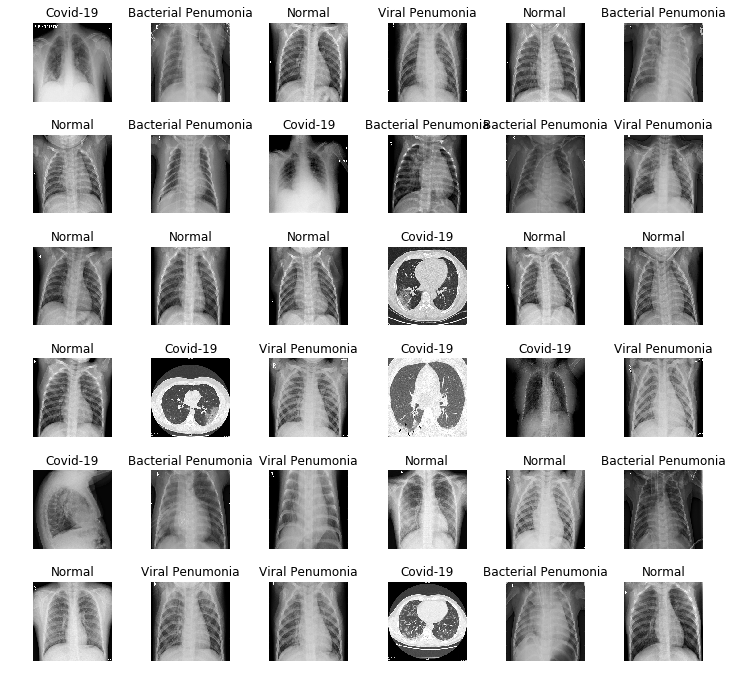

In [13]:
#Visualize Dataset - Create a grid of 36 images (6 rows, 6 columns) and the labels associated with it

# Create a grid of 36 images along with their corresponding labels
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)    
plt.show()


### Model Development: Residual Network (RESNET)

In [14]:
#Import Model with pre-trained weights
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [15]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
#Freezing layers in the model
for layer in basemodel.layers[:-10]:
    layers.trainable = False

In [17]:
#Build and Train Deep Learning Model.
#Create head model the base model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4)) (headmodel) #average pooling layer
headmodel = Flatten(name = 'flatten') (headmodel) #Add a flatten layer
headmodel = Dense(256, activation = 'relu') (headmodel) # Add a dense fully colelcted ANN with 256 neurons and relu as an activation function
headmodel = Dropout(0.3)(headmodel) #Dropout 30% of the neurons for generalization
headmodel = Dense(120, activation = 'relu') (headmodel) # Add a dense fully colelcted ANN with 256 neurons and relu as an activation function
headmodel = Dropout(0.2)(headmodel) #Dropout 20% of the neurons for generalization. #This whole process is trial and error.
headmodel = Dense(4, activation = 'softmax') (headmodel) #Add output *4 outputs. In the output layer it should be softmax because of classification.



In [18]:
#This is the final model where I combine the input coming from base model and output coming from head model
model = Model(inputs = basemodel.input, outputs = headmodel)

In [19]:
#Compile the model and set loss function. Since it's multiclass classification, set loss to be categorical crossentropy.

model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4), metrics = ['accuracy']) #learning rate 1e-4 and choose accuracy as metrics

In [21]:
#Using early stopping to exist training if validation loss is not decreasing after a certain number of epochs (Patience)
#This is to avoid over fitting on the training data
earlystoping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20) #monitor validation loss, mode to be minimum and epochs to be 20

#Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', verbose = 1, save_best_only = True ) #saving one single file to sabve the model

In [22]:
#Generate images and filt model to the images
train_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'training')

Found 428 images belonging to 4 classes.


In [23]:
#Validation Generator
val_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'validation')


Found 104 images belonging to 4 classes.


In [38]:
#Specify history
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n//4, epochs = 10, validation_data = val_generator, validation_steps = val_generator.n//4, callbacks = [checkpointer, earlystoping])

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.7897
Epoch 00001: val_loss did not improve from 2.07232
107/107 [==============================] - 282s 3s/step - loss: 0.6116 - accuracy: 0.7897 - val_loss: 11.1358 - val_accuracy: 0.2500
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.3978 - accuracy: 0.8668
Epoch 00002: val_loss did not improve from 2.07232
107/107 [==============================] - 298s 3s/step - loss: 0.3978 - accuracy: 0.8668 - val_loss: 4.3892 - val_accuracy: 0.2788
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.8785
Epoch 00003: val_loss did not improve from 2.07232
107/107 [==============================] - 284s 3s/step - loss: 0.3417 - accuracy: 0.8785 - val_loss: 8.3662 - val_accuracy: 0.2981
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.1952 - accuracy: 0.9439
Epoch 00004: val_loss did not improve from 2.07232
107/107 [======

Training accuracy is 0.4500 and val accuracy is 21% which is not good. 

In [39]:
#Enhance the model architecture with trial and error
#Create head model the base model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4)) (headmodel) #average pooling layer
headmodel = Flatten(name = 'flatten') (headmodel) #Add a flatten layer
headmodel = Dense(256, activation = 'relu') (headmodel) # Add a dense fully colelcted ANN with 256 neurons and relu as an activation function
headmodel = Dropout(0.3)(headmodel) #Dropout 30% of the neurons for generalization
headmodel = Dense(256, activation = 'relu') (headmodel) # Add a dense fully colelcted ANN with 256 neurons and relu as an activation function
headmodel = Dropout(0.3)(headmodel) #Dropout 20% of the neurons for generalization. #This whole process is trial and error.
headmodel = Dense(4, activation = 'softmax') (headmodel) #Add output *4 outputs. In the output layer it should be softmax because of classification.



In [40]:
#This is the final model where I combine the input coming from base model and output coming from head model
model = Model(inputs = basemodel.input, outputs = headmodel)

In [41]:
#Compile the model and set loss function. Since it's multiclass classification, set loss to be categorical crossentropy.

model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4), metrics = ['accuracy']) #learning rate 1e-4 and choose accuracy as metrics

In [42]:
#Using early stopping to exist training if validation loss is not decreasing after a certain number of epochs (Patience)
#This is to avoid over fitting on the training data
earlystoping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20) #monitor validation loss, mode to be minimum and epochs to be 20

#Save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', verbose = 1, save_best_only = True ) #saving one single file to sabve the model

In [43]:
#Generate images and filt model to the images
train_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'training')
#Validation Generator
val_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'validation')


Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [44]:
#This code takes a long time to run
#Specify history
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n//4, epochs = 25, validation_data = val_generator, validation_steps = val_generator.n//4, callbacks = [checkpointer, earlystoping])

Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 0.2621 - accuracy: 0.9322
Epoch 00001: val_loss improved from inf to 0.40510, saving model to weights.hdf5
107/107 [==============================] - 284s 3s/step - loss: 0.2621 - accuracy: 0.9322 - val_loss: 0.4051 - val_accuracy: 0.8942
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9720
Epoch 00002: val_loss did not improve from 0.40510
107/107 [==============================] - 259s 2s/step - loss: 0.1701 - accuracy: 0.9720 - val_loss: 0.7237 - val_accuracy: 0.8173
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9930
Epoch 00003: val_loss did not improve from 0.40510
107/107 [==============================] - 266s 2s/step - loss: 0.0513 - accuracy: 0.9930 - val_loss: 0.5910 - val_accuracy: 0.8846
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9953
Epoch 00004: val_loss did not improve

### Model Evaluation

In [53]:
#Take the model loss, accuracy, validation loss and validation accuracy
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

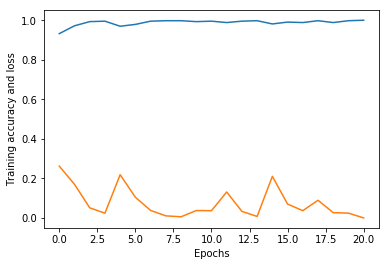

In [54]:
#Plot the training accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training accuracy and loss')
plt.show()

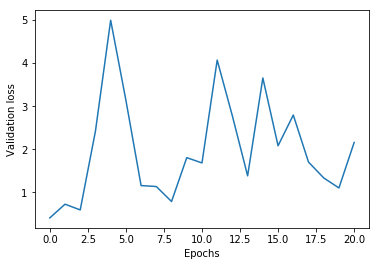

In [55]:
#Plot the validation loss
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.show()

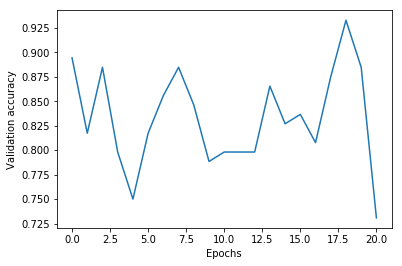

In [56]:
##Plot the validation loss
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.show()

In [57]:
#Now let's look at the testing data set - the data that has never been seen by the model that was trained
test_directory = "C:\\Users\\tawsi\\Chest_X_Ray\\Test"

In [59]:
#Generate data using test generator from my directory
test_gen = ImageDataGenerator (rescale = 1./255) #rescale the image
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical')

#Evaluate the model 
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n//4, verbose = 1)
print('Accuracy Test: {}'.format(evaluate[1])) #1 represents the accuracy

Found 40 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
 1/10 [==>...........................] - 0s 231ms/step - loss: 2.9509 - accuracy: 0.7000
Accuracy Test: 0.699999988079071


In [61]:
#Now let's plot the confusion matrix, the classification report and accuracy score on the testing data set

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [62]:
#Take a look at the store
score = accuracy_score(original, prediction)
print('Test Accuracy: {}'.format(score))

Test Accuracy: 0.725


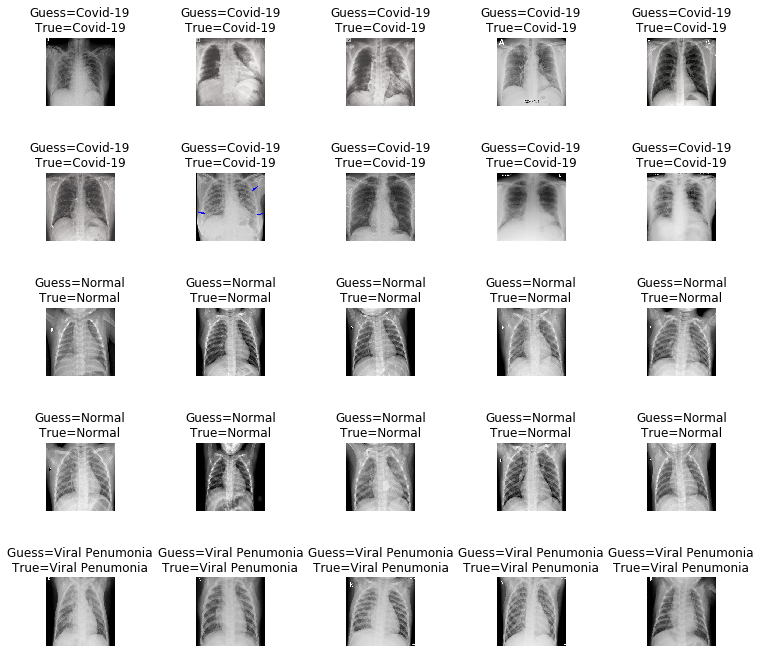

In [63]:
#Plot the grid to show predictions and show our original labels
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [64]:
#Let's print classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.71      1.00      0.83        10
           2       0.54      0.70      0.61        10
           3       0.67      0.20      0.31        10

    accuracy                           0.73        40
   macro avg       0.73      0.73      0.69        40
weighted avg       0.73      0.72      0.69        40



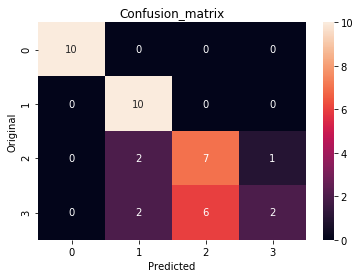

In [68]:
#Let's plot confusion matrix for the original and the predicted values
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

plt.show()


### Conclusion

The accuracy of the ResNet Model on new data is 73%

### Intuition Behind Convolutional Neural Network

The first CNN layers are used to extract high level general features. These convolutional layers are added at first to extract important critical features out of the images. THese feature detectors are called Kernels. Additional layers (Kernels) extract more features. Usually there are multiple Kernels to extract features before the features are passed through fully connected (Dense) layers of Artificial Neural Networks. Between the convolutional layer and the ANN an activation function is applied. The activation functions are used to increase the parsity of the matrix. The features from the CNN kernels get pooled (down sampled) into another layer containing the most important features. Those features are then flattened (from 2D to 1D) after which the features pass through ANN for prediction. The last couple of layers are used to perform classification on a specific task. 

### Concept of RESNET(Residual Network)

As CNNs gro deeper, vanishing gradient tend to occur which negatively impact network perofrmance. Vanishing gradient problem occurs when the gradient is back-propagated to earlier layers which results in a very small gradient. Residual Neural Network includes *Skip Connection* feature which enables training of 152 layers without vanishing gradient issues. Resnet works by adding *Identity Mappings* on top of CNN. ImageNet contains 11 million images and 11,000 categories. ImageNet is used to train ResNet deep network.

### Intuition Behind Transfer Learning

Transfer Learning is a Machine Learning technique in which a network that has been trained to perform a specific task is being reused (repurposed) as a starting point for another similar task. Transfer learning is widely used since starting from a pre-trained model can dramatically reduce the computational time required if training is performed from scratch. E.g. An Ice skater will probably be better at Snowboarding.

Transfer learning is the improvement of learning in a new task through the transfer of knowledge from a related task that has already been learned. In transfer learning, a base (reference) Artificial Neural NEtwork on a base data set and function is being trained. Then, this trained network weights are then repurposed in a second ANN to be trained on a new dataset and funuction. Transfer Learning works great if the features are general, such that trained weights can effectively repurposed. Intelligence is being transferred from the base network to the newly target network.